<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Hard Negative Sampling for Image Classification

You built an image classification model, evaluated it on a validation set and got a decent accuracy. Now you deploy the model for the real-world scenario. And soon, you'll find that the model underperforms than expected.

This is quite common scenario (and inevitable) when we build a machine learning model because we cannot collect all the possible samples. Your model is supposed to learn the features that describe the target classes the best, but in reality, it learns the best features **to classify your dataset**. For example, if we have *carton* photos with white background only, the model may learn the background color to classify *carton* objects.

Hard negative sampling (or hard negative mining) is a useful technique to address this pitfall, that is when you find falsely classified samples, explicitly create examples from them and add to your training set. The technique is widely used in obejct detection scenario where you cannot collect all the negative (non-target object) samples. This is why the technique is called hard 'negative' sampling.

This concept can be applied to image classification problems. In this notebook, we train our model on a training set as usual, test the model on un-seen data and see if the model performs well. If not, we introduce the misclassified (hard) samples into the training set and re-train the model with it.

Training workflow is as follows:
1. Prepare training set `T` and unlabeled set `U`
2. Load a pre-trained ImageNet model
3. Train the model on `T`
4. Score the model on `U`
5. Identify hard images in `U`
6. Annotate the hard samples and add to `T`
7. Repeat step 3-6 if needed

Let's get started.

In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [25]:
import sys
sys.path.append("../../")
from functools import partial 

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
# fastai
import fastai
from fastai.vision import (
    # data-modules
    CategoryList, DatasetType, get_image_files, ImageList, imagenet_stats, untar_data, URLs, 
    # model-modules
    cnn_learner, models, ClassificationInterpretation, 
)
from fastai.metrics import accuracy

from utils_cv.classification.model import (
    IMAGENET_IM_SIZE as IMAGE_SIZE,
    TrainMetricsRecorder
)
from utils_cv.classification.plot import plot_pr_roc_curves
from utils_cv.classification.widget import ResultsWidget
from utils_cv.classification.data import Urls
from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import which_processor
from utils_cv.common.image import show_im_files
from utils_cv.common.misc import set_random_seed

print(f"Fast.ai version = {fastai.__version__}")
which_processor()

Fast.ai version = 1.0.48
Fast.ai (Torch) is using GPU: Tesla K80
Available / Total memory = 9150 / 11441 (MiB)


In [3]:
EPOCHS        = 5
LEARNING_RATE = 1e-4
BATCH_SIZE    = 16
ARCHITECTURE  = models.resnet50
SEED          = 10

## 1. Prepare datasets

To demonstrate the hard negative sampling usecase, we introduce one more class into our *fridge obejct* classification problem: the class *pet*. For that, we use [The Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/).

So, our end-goal is to classify an image into one of following classes: `watter_bottle`, `carton`, `can`, `milk_bottle`, and `pet`.

First, let's see how the two datasets look like.

In [4]:
fridge_datapath = Path(unzip_url(Urls.fridge_objects_path, exist_ok=True))
pet_datapath = Path(untar_data(URLs.PETS))/'images'

/data/anaconda/envs/cvbp/lib/python3.6/site-packages/fastai/datasets.py:159: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


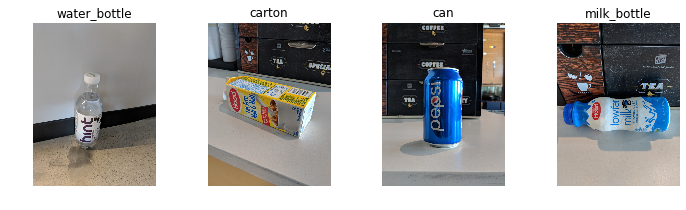

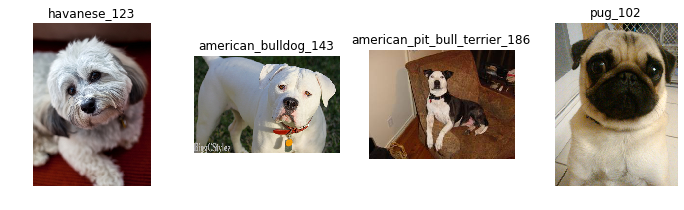

In [5]:
fridge_object_examples = [
    get_image_files(fridge_datapath/'water_bottle')[0],
    get_image_files(fridge_datapath/'carton')[0],
    get_image_files(fridge_datapath/'can')[0],
    get_image_files(fridge_datapath/'milk_bottle')[0],
]
pet_examples = get_image_files(pet_datapath)[:4]

show_im_files(fridge_object_examples, ['water_bottle', 'carton', 'can', 'milk_bottle'])
show_im_files(pet_examples)

Now, we prepare three datasets out of those two as follows:
* The initial training set `T` to include *fridge objects* as well as **some of** *pet* images.
* Unlabeled set `U`. Here, we include only *pets* for simplicity (so that we don't need to browse and annotate manually). 
* Validation set `V` to have both *fridge objects* and *pets*. We evaluate our model on this set.

In [6]:
fridge_objects = (ImageList.from_folder(fridge_datapath)
                  .split_by_rand_pct(valid_pct=0.2, seed=SEED)
                  .label_from_folder())
pets = (ImageList.from_folder(pet_datapath)
        .split_by_rand_pct(valid_pct=0.2, seed=SEED))

In [7]:
import os
import shutil
from tempfile import TemporaryDirectory
tmpdir = TemporaryDirectory()
data_path = Path(tmpdir.name)/'data'


def copy_files(files, dst):
    os.makedirs(dst, exist_ok=True)
    for f in files:
        shutil.copy(f, dst)

# Training set T
copy_files(fridge_objects.train.items, data_path/'train')
copy_files(pets.train.items[:10], data_path/'train')  # add 10 pet images to our initial training set.

# Validation set V
copy_files(fridge_objects.valid.items, data_path/'valid')
copy_files(pets.valid.items, data_path/'valid')

# Test set, in our case, it is U (unlabeled data)
copy_files(pets.train.items[10:], data_path/'test')

In [8]:
# label function
y_dict = {
    os.path.basename(n): str(fridge_objects.train.y[i]) for i, n in enumerate(fridge_objects.train.items)
}
y_dict.update({
    os.path.basename(n): str(fridge_objects.valid.y[i]) for i, n in enumerate(fridge_objects.valid.items)
})

def get_y_fn(x):
    x = os.path.basename(x)
    return y_dict.get(x) if x in y_dict else 'pet'

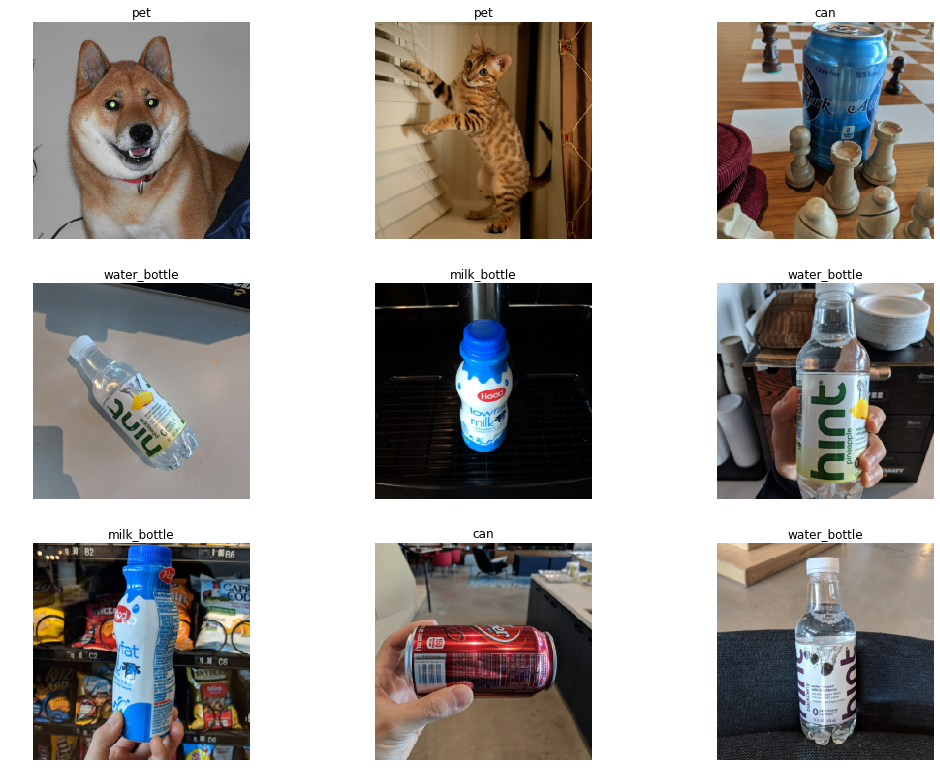

In [9]:
set_random_seed(SEED)
data = (ImageList.from_folder(data_path)
        .split_by_folder()
        .label_from_func(get_y_fn)
        .add_test_folder()
        .transform(size=IMAGE_SIZE) 
        .databunch(bs=BATCH_SIZE) 
        .normalize(imagenet_stats))
data.show_batch(rows=3, figsize=(15,11))

In [10]:
print(f'number of classes: {data.c} = {data.classes}')
print(data.batch_stats)

number of classes: 5 = ['can', 'carton', 'milk_bottle', 'pet', 'water_bottle']
<bound method ImageDataBunch.batch_stats of ImageDataBunch;

Train: LabelList (118 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
carton,milk_bottle,carton,pet,milk_bottle
Path: /tmp/tmpu3p69iyq/data;

Valid: LabelList (1504 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pet,pet,pet,water_bottle,pet
Path: /tmp/tmpu3p69iyq/data;

Test: LabelList (5902 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /tmp/tmpu3p69iyq/data>


> Note, test set doesn't have labels (`EmptyLabelList`)

## 2. Load a pre-trained ImageNet model

We use [ResNet50](https://arxiv.org/abs/1512.03385) model pre-trained on [ImageNet](http://www.image-net.org/), same as [01_training_introduction notebook](./01_training_introduction.ipynb).

In [11]:
learn = cnn_learner(
    data,
    ARCHITECTURE,
    metrics=[accuracy],
    callback_fns=[partial(TrainMetricsRecorder, show_graph=True)]
)

## 3. Train the model on *T*

In [12]:
# We are training all the layers
learn.unfreeze()

epoch,train_loss,valid_loss,train_accuracy,valid_accuracy,time
0,1.681814,1.087654,0.339286,0.701463,00:25
1,1.064419,0.852952,0.812500,0.846410,00:15
2,0.749044,0.626171,0.964286,0.894947,00:15
3,0.557041,0.482200,0.991071,0.916223,00:15
4,0.426663,0.388222,1.000000,0.936170,00:15


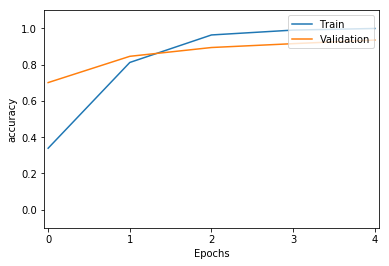

In [13]:
learn.fit(EPOCHS, LEARNING_RATE)

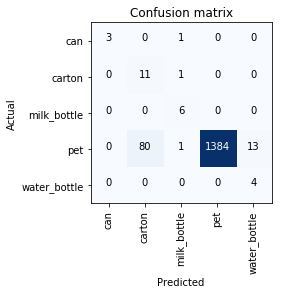

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [15]:
interp.most_confused()

[('pet', 'carton', 80),
 ('pet', 'water_bottle', 13),
 ('can', 'milk_bottle', 1),
 ('carton', 'milk_bottle', 1),
 ('pet', 'milk_bottle', 1)]

As you can see, our model confuses `pet` with `carton`.

## 4. Score the model on *U* 

In [16]:
pred_outs = learn.get_preds(ds_type=DatasetType.Test)  # Note, 'Test' is our unlabeled-set U
pred_outs = np.array(pred_outs[0].tolist())  # Convert Tensor to np array

## 5. Hard negative sampling

In [17]:
preds = np.argmax(pred_outs, axis=1)
wrong_pred_ids = np.where(preds!=3)[0]  # We already know the dataset U only includes 'pet' == 3

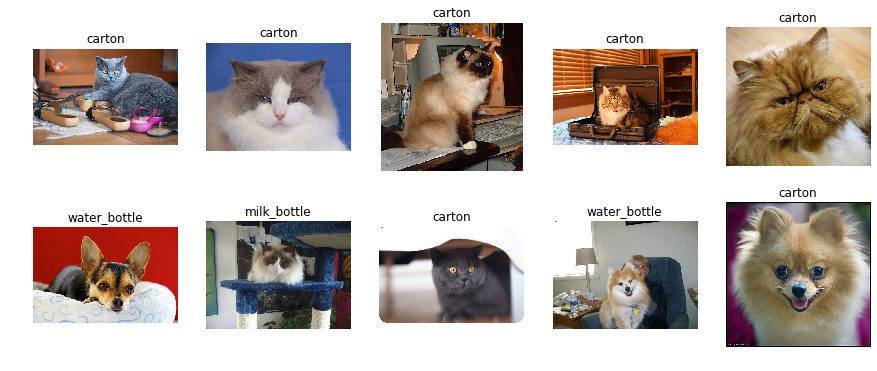

In [19]:
wrong_labels = [data.classes[i] for i in preds[wrong_pred_ids][:10]]
show_im_files(data.test_ds.items[wrong_pred_ids[:10]], wrong_labels, rows=2)

Our model classified cute pets as `carton`, `water_bottle`, and `mile_bottle`. Let's fix this.

## 6. Add hard images to training set *T*

We add the hard samples into the training set and re-train the model.

In [20]:
copy_files(data.test_ds.items[wrong_pred_ids], data_path/'train')

In [21]:
new_data = (ImageList.from_folder(data_path)
    .split_by_folder()
    .label_from_func(get_y_fn)
    .transform(size=IMAGE_SIZE) 
    .databunch(bs=BATCH_SIZE) 
    .normalize(imagenet_stats))

epoch,train_loss,valid_loss,train_accuracy,valid_accuracy,time
0,0.947495,0.164203,0.645833,0.994681,00:23
1,0.561000,0.169621,0.912037,0.999335,00:23
2,0.418714,0.057424,0.921296,1.000000,00:23
3,0.336273,0.076184,0.960648,1.000000,00:23
4,0.295393,0.061145,0.956019,1.000000,00:24


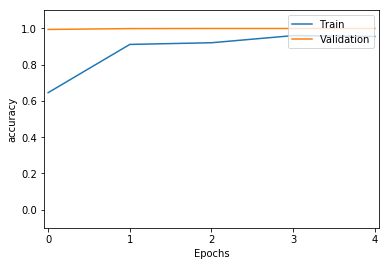

In [22]:
learn.data = new_data
learn.fit(EPOCHS, LEARNING_RATE)

As you can see, we have low training-accuracy at the beginning even we re-use the model we already trained. This is because of the newly added hard examples.

Finally, let's see how the model learned from the new data.

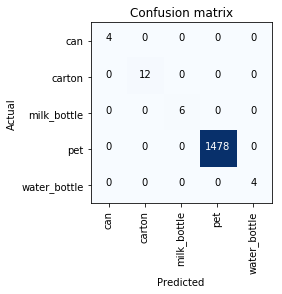

In [32]:
interp_new = ClassificationInterpretation.from_learner(learn)
interp_new.plot_confusion_matrix()

Below is the previous confusion matrix we showed earlier (the result before we re-trained the model on the hard-samples)

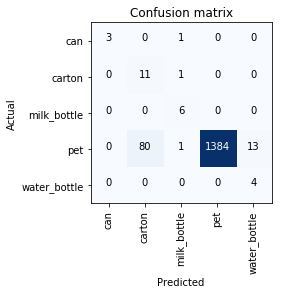

In [33]:
interp.plot_confusion_matrix()

After the model learned from hard samples, it classifies `pet` and `carton` much better! 
